In [289]:
#essential tools
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from utilidades import load_data
import seaborn as sns

#distance and classic clustering tools
from scipy.spatial.distance import pdist
import scipy.cluster.hierarchy as hac
from sklearn.metrics import pairwise_distances
from statsmodels.tsa.stattools import ccf
from functools import reduce

#network-communities and spatial tools
import networkx as nx
import networkx.algorithms.community as nxcom
import geopandas as gpd
from shapely.geometry import linestring
import community


plt.rcParams['figure.dpi']=100
plt.rcParams['figure.figsize'] = (15,5)

# funtion to scale time series to adecuately compare multivariate time series. 
def ts_scaled(ts):
    return 2*(ts - ts.min())/( ts.max()-ts.min() )

# functions to plot network communities 

def set_node_community(G,communities):
    """Add community to node attributes"""
    for c, v_c in enumerate(communities):
        for v in v_c:
            # Add 1 o save 0 for external edges
            G.nodes[v]['community']=c+1

def set_edge_community(G):
    """Find internal edges and add their community to their attributes"""
    for v, w in G.edges:
        if G.nodes[v]['community']==G.nodes[w]['community']:
            # internal edge, mark with community
            G.edges[v,w]['community']=G.nodes[v]['community']
        else:
            # External edge, mark as 0
            G.edges[v,w]['community']=0

def get_color(i,r_off=1,g_off=1,b_off=1):
    """Assign a color to a vertex"""
    r0,g0,b0=0,0,0
    n=16
    low,high=0.1,0.9
    span=high-low
    r=low
    r = low + span * (((i + r_off) * 3) % n) / (n - 1)
    g = low + span * (((i + g_off) * 5) % n) / (n - 1)
    b = low + span * (((i + b_off) * 7) % n) / (n - 1)
    return (r,g,b)

# Preprocessing 

In [252]:
pop_ts = pd.read_csv("../normalization/Population_filtered.csv",index_col=0)
gdp_ts = pd.read_csv("../normalization/GDP_filtered.csv",index_col=0)

pop_ts_scaled=pop_ts.copy(deep=True)
gdp_ts_scaled = gdp_ts.copy(deep=True)

#scale the time series
pop_ts_scaled['value'] = pop_ts.groupby(['country.value'])['value'].apply(ts_scaled)
gdp_ts_scaled['value'] = gdp_ts.groupby(['country.value'])['value'].apply(ts_scaled)
gdp_ts_scaled=gdp_ts_scaled.drop(columns=['countryiso3code','indicator.value'])
pop_ts_scaled=pop_ts_scaled.drop(columns=['countryiso3code','indicator.value'])

<AxesSubplot:xlabel='date', ylabel='value'>

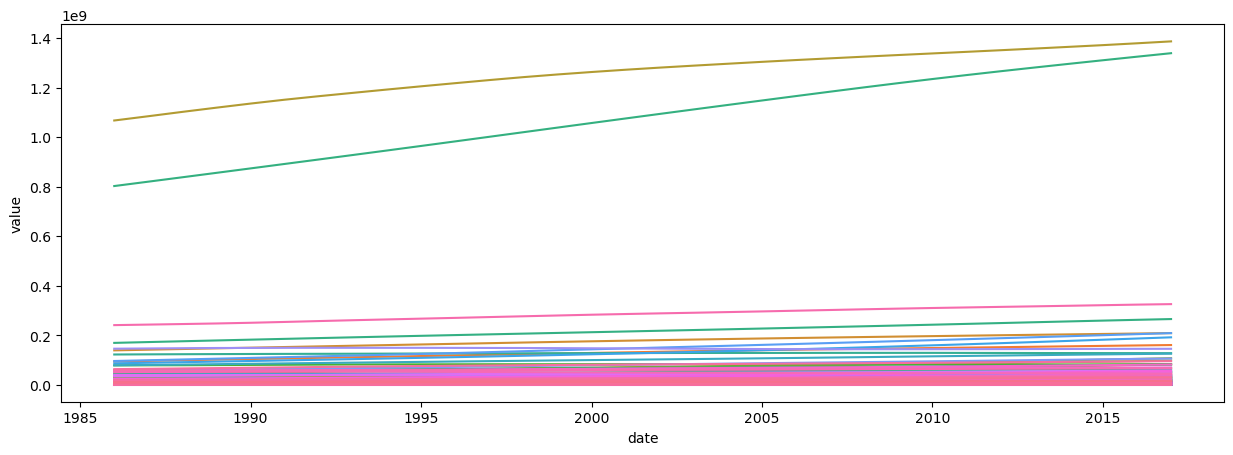

In [581]:
sns.lineplot(hue='country.value',x='date',y='value',data=pop_ts,legend=False)

<AxesSubplot:xlabel='date', ylabel='value'>

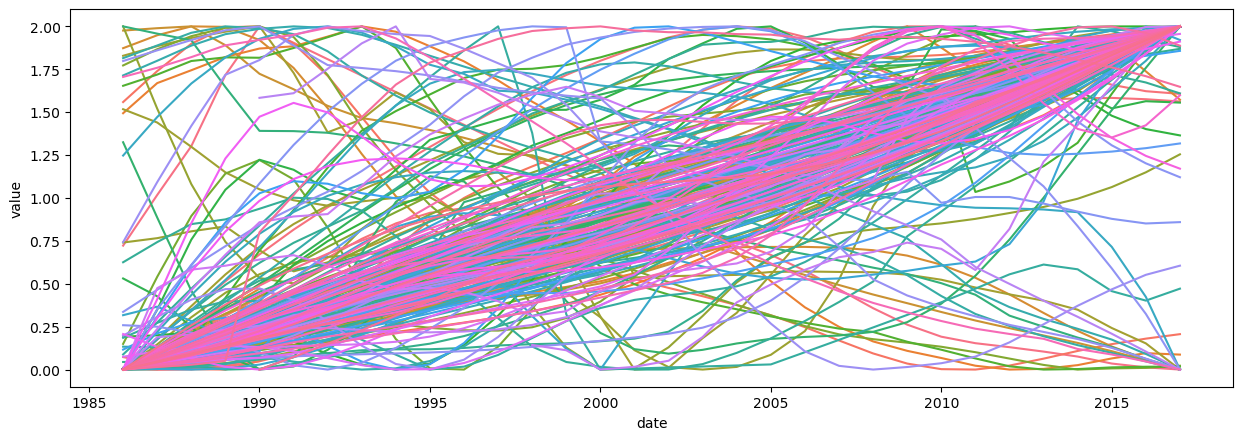

In [582]:
sns.lineplot(hue='country.value',x='date',y='value',data=pop_ts_scaled,legend=False)

<AxesSubplot:xlabel='date', ylabel='value'>

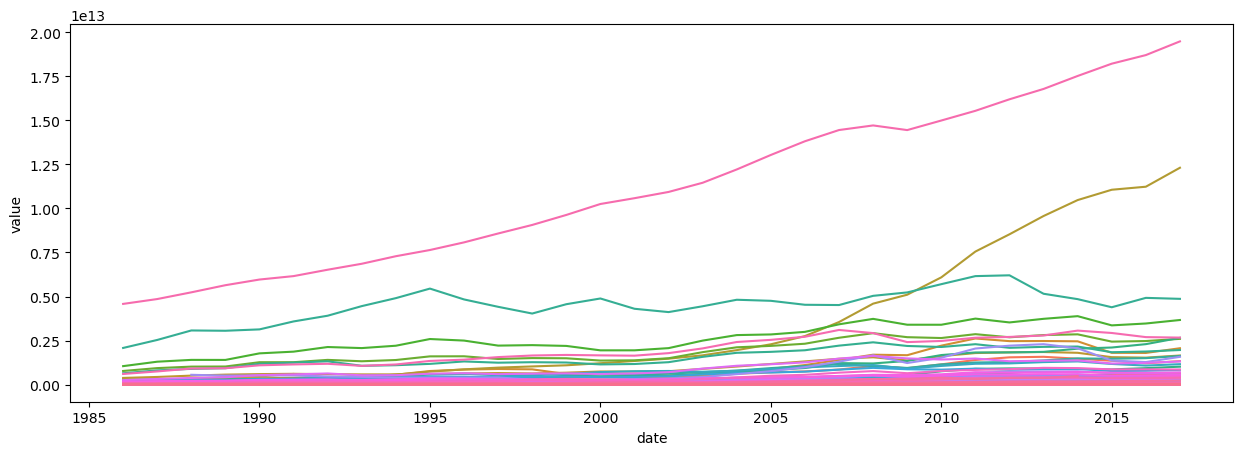

In [583]:
sns.lineplot(hue='country.value',x='date',y='value',data=gdp_ts,legend=False)

<AxesSubplot:xlabel='date', ylabel='value'>

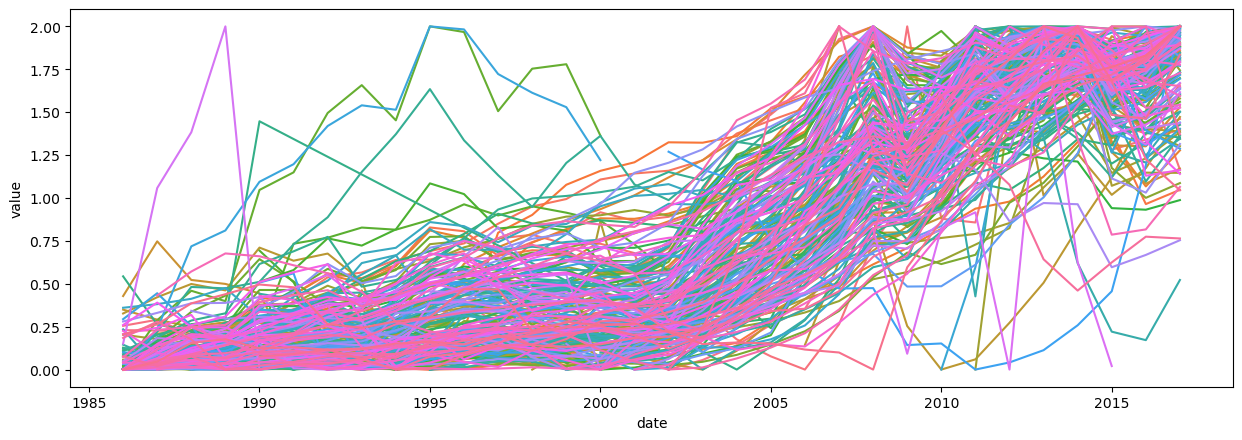

In [584]:
sns.lineplot(hue='country.value',x='date',y='value',data=gdp_ts_scaled,legend=False)

In [253]:
### load antifragility time series.

afs=load_data()
pre_a=afs['af_ye']
a=pre_a.rename(columns={'Unnamed: 0':'country','Unnamed: 1':'date'})

# Get same countries of both datasets.
countries = a.merge(pop_ts_scaled,how='inner',left_on=['country','date'],right_on=['country.value','date'])['country'].unique()

a=a[np.isin(a['country'],countries)]

In [254]:
def set_date_index(df):
    df = df.set_index('date')
    df.index=pd.to_datetime(df.index,format="%Y")
    return df

In [255]:
########################### Para plotear y guardar series de tiempo totales de casos ex_pr, ex_pr2, in_vl, in_ex, etc.#######################################

# antifragilidad_experimentos = [a.loc[:,['country','date',i]] for i in a.columns[2:] ]
# for index,a_x in enumerate(antifragilidad_experimentos):
#     antifragilidad_experimentos[index] = set_date_index(a_x)
    
# for a in antifragilidad_experimentos:
#     a=a.pivot(columns='country')
#     _=a.plot(legend=False)
#     _.set_title(a.columns[0][0])
#     _.set_ylim(-1,1)
#     plt.savefig(a.columns[0][0])
#     plt.close()

From what I saw, I consider the correct cases to analyze are **af_ex_pr** and **af_ex_vl**.

In [256]:
af_ex_pr = set_date_index(a.loc[:,['country','date','af_ex_pr']]).pivot(columns='country')
af_ex_vl = set_date_index(a.loc[:,['country','date','af_ex_vl']]).pivot(columns='country')

<AxesSubplot:xlabel='date'>

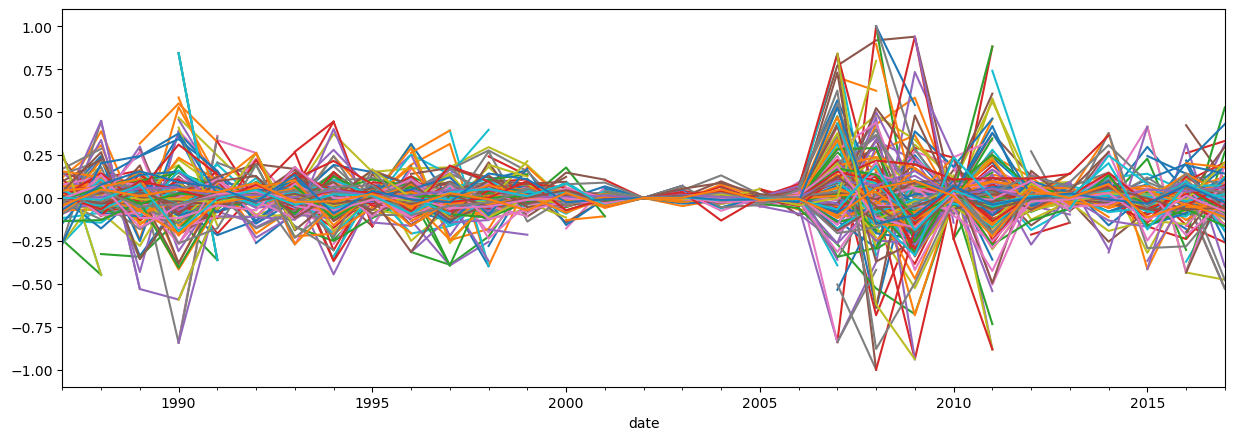

In [12]:
af_ex_pr.plot(legend=False)

<AxesSubplot:xlabel='date'>

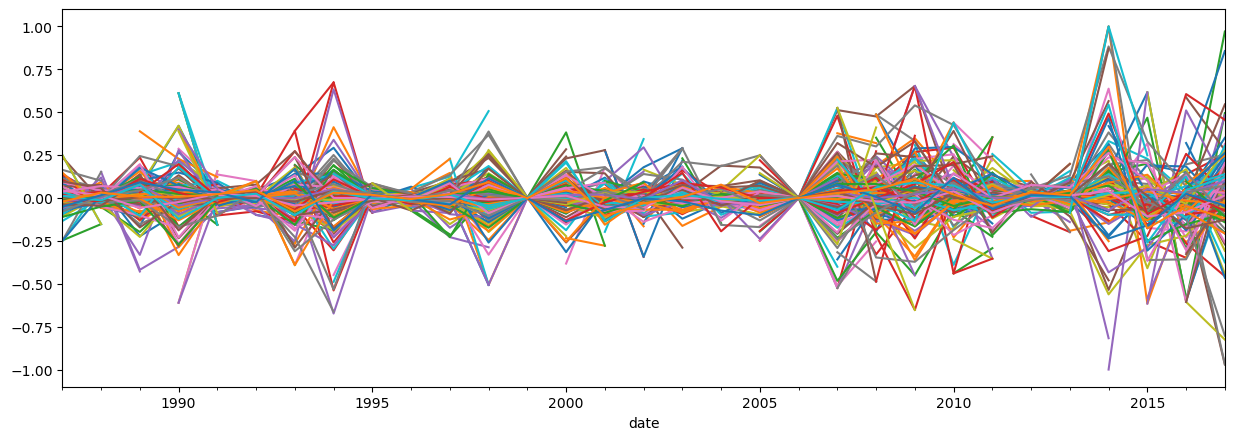

In [328]:
af_ex_vl.plot(legend=False)

In [257]:
#Format as pivot tables

gdp_ts_scaled=gdp_ts_scaled[np.isin(gdp_ts_scaled['country.value'],countries)]
pop_ts_scaled=pop_ts_scaled[np.isin(pop_ts_scaled['country.value'],countries)]

gdp_ts_scaled = set_date_index(gdp_ts_scaled.loc[:,['country.value','date','value']]).pivot(columns='country.value',values='value')
pop_ts_scaled = set_date_index(pop_ts_scaled.loc[:,['country.value','date','value']]).pivot(columns='country.value',values='value')

# paired to have the same number of observations in all datasets
pop_ts_scaled=pop_ts_scaled['1987':]
gdp_ts_scaled=gdp_ts_scaled['1987':]

gdp_ts_scaled.columns.name='country'
pop_ts_scaled.columns.name='country'

# Sort by country name all datsets to have consistency in the clustering results

arrays = [af_ex_pr,af_ex_vl,gdp_ts_scaled,pop_ts_scaled]
for i,ar in enumerate(arrays):
    ar.T.sort_index(inplace=True)
    arrays[i] = ar.T
    
# drop NA values and get new set of countries that are simultanously in all datasets. 
arrays = [ar.dropna(axis=0).reset_index() for ar in arrays]    
countries_v2=reduce(lambda left,right: pd.merge(left,right, on='country'),arrays)['country']

# Transform multindex labels to single index labels of antifragility datatsets

af_ex_pr = af_ex_pr.T.reset_index().drop(columns='level_0').T.set_axis(af_ex_pr.T.index.get_level_values(1),axis='columns').drop('country',axis=0)
af_ex_vl = af_ex_vl.T.reset_index().drop(columns='level_0').T.set_axis(af_ex_vl.T.index.get_level_values(1),axis='columns').drop('country',axis=0)

# Multivariate time series clustering using Euclidean distance.

1. Define a tensor X of dimensions: variables x number-of-countries-(objects) x number-of-time-points
2. Compute distance matrix (dissimilarity matrix, i.e., higher values between pairs of countries correspond to dissimilar ) 

In [260]:
# X=[af_ex_pr, af_ex_vl, gdp_ts_scaled, pop_ts_scaled]
X=[af_ex_pr]
X=[ arr.T[np.isin(arr.columns,countries_v2)] for arr in X ]

In [185]:
np.array(X).shape

(1, 64, 31)

### Test multivariate euclidean distance measure

In [166]:
_TEST = np.array([[np.sin(np.arange(0,10,1)),np.sin(np.arange(0,10,1)),np.arange(0,10,1)],[2*np.random.rand(10),2*np.random.rand(10),2*np.random.rand(10)]]) 

In [167]:
_TEST.shape

(2, 3, 10)

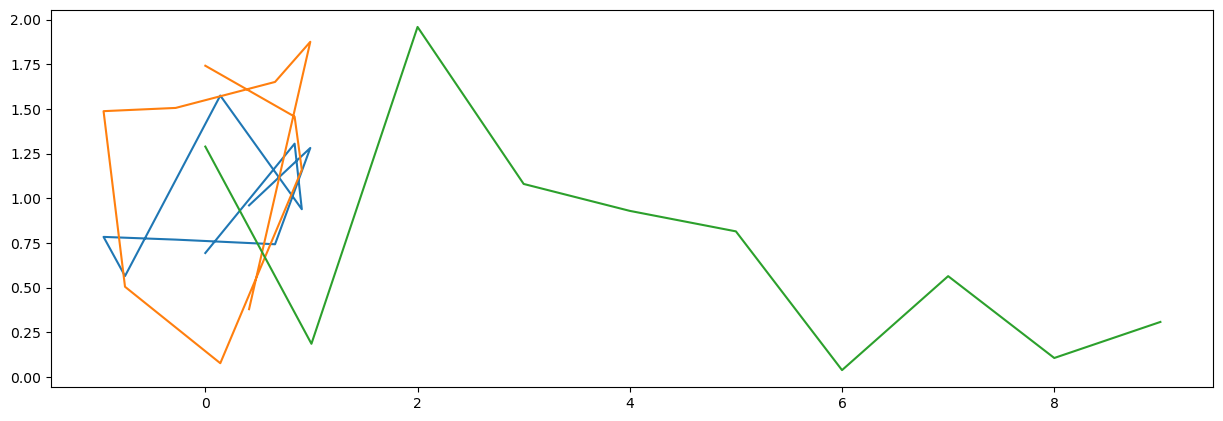

In [168]:
plt.plot(_TEST[0].T,_TEST[1].T)

In [169]:
_A = [pairwise_distances(x,metric='euclidean')**2 for x in _TEST] 

_D = np.sqrt(np.sum(np.array(_A), axis=0))
_dissim = pd.DataFrame(_D)

In [170]:
_dissim

,0,1,2
0,0.000000,2.443586,16.597930
1,2.443586,0.000000,16.752934
2,16.597930,16.752934,0.000000


/home/rogelio/anaconda3/envs/geopandas_env/lib/python3.7/site-packages/seaborn/matrix.py:620: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


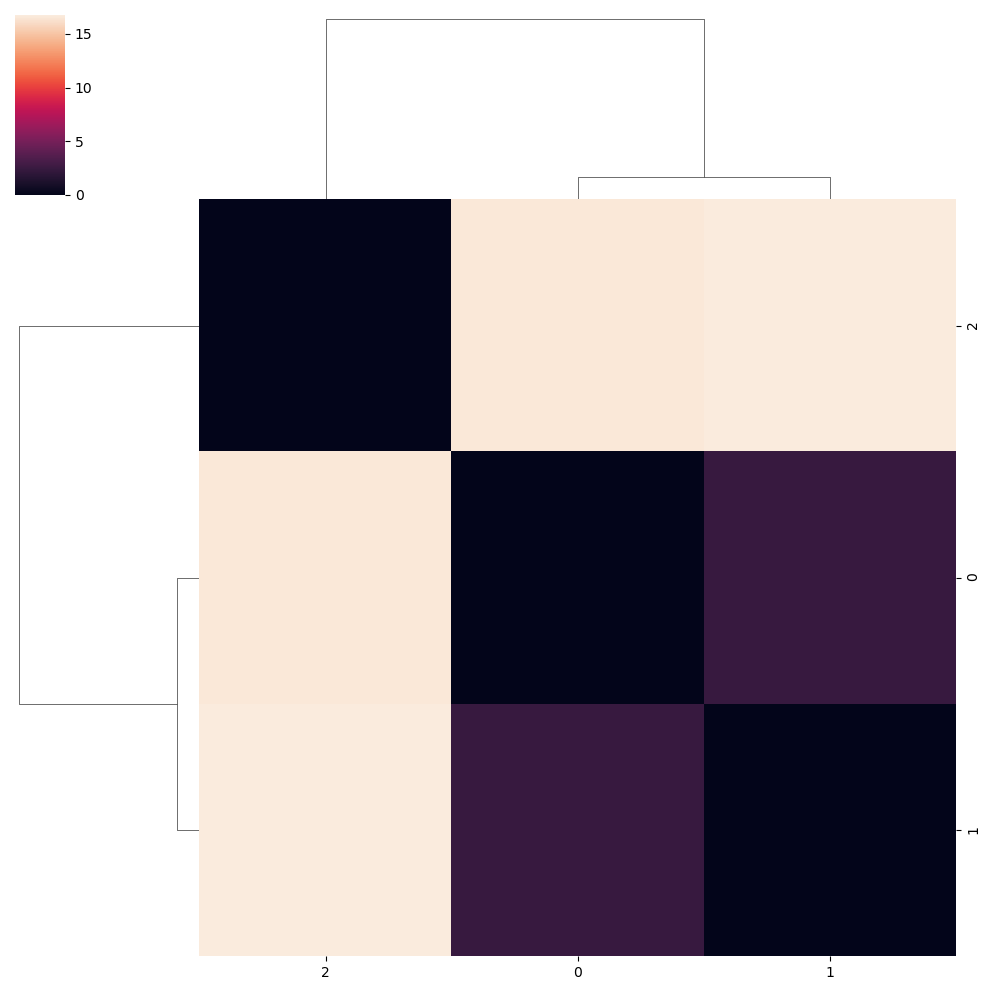

In [171]:
sns.clustermap(_dissim,method='complete')

## Using only antifragility ex_pr

In [305]:
def max_xcorr(x,y):
    return ccf(x,y,unbiased=False)
    
# METRIC = 'euclidean'
METRIC = max_xcorr

In [313]:
_albania=X[0].loc['Albania']
_argentina=X[0].loc['Argentina']

In [316]:
ccf(_albania,_argentina)

array([-0.2752438 ,  0.25182411,  0.13506412, -0.0933297 ,  0.30413476,
       -0.08235439,  0.06283481, -0.02850134, -0.09036047,  0.05611317,
       -0.10874896, -0.06887022, -0.11012045,  0.16613693, -0.1644777 ,
       -0.03783028,  0.26359411, -0.03969103,  0.1817963 ,  0.06164212,
       -0.21341   ,  0.07170495, -0.19614475, -0.09352042, -0.0075224 ,
       -0.01648995, -0.04951205,  0.29857854, -0.0016119 ,  0.15194511,
        0.1653353 ])

In [317]:
ccf(_argentina,_albania)

array([-0.2752438 , -0.36592189,  0.22877985,  0.10120229, -0.25958567,
        0.28307385,  0.08406387, -0.33709196,  0.17366025, -0.3301485 ,
        0.18927792,  0.36383416, -0.26578689,  0.01677609, -0.03670348,
       -0.38399873,  0.0302556 ,  0.93619232, -0.44488811, -0.35254029,
        0.5741095 , -0.23179277, -0.45451419,  0.30662567,  0.40012365,
       -0.46137831, -0.04020356,  0.55434311, -0.53946528,  0.16723198,
        0.11738354])

In [306]:
A = [pairwise_distances(x,metric=METRIC)**2 for x in X] 

D = np.sqrt(np.sum(np.array(A), axis=0))
dissim = pd.DataFrame(D,index=countries_v2,columns=countries_v2)

In [301]:
assert np.isclose(np.sqrt(A[0][1,0]), D[1,0])

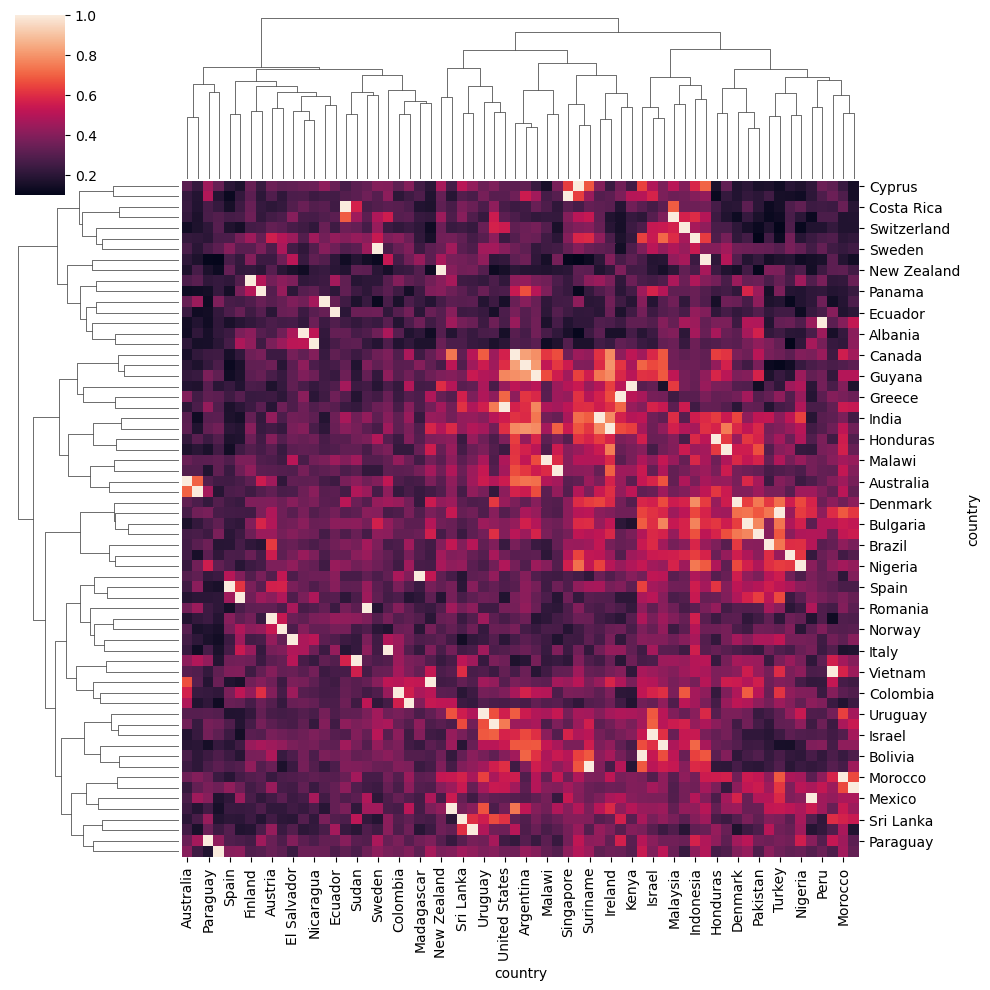

In [297]:
sns.clustermap(dissim,method='complete')

In [280]:
A_computed = [pdist(x,metric=METRIC)**2 for x in X] 
D_computed = np.sqrt(np.sum(np.array(A_computed), axis=0))

In [281]:
Z = hac.linkage(D_computed,method='complete')

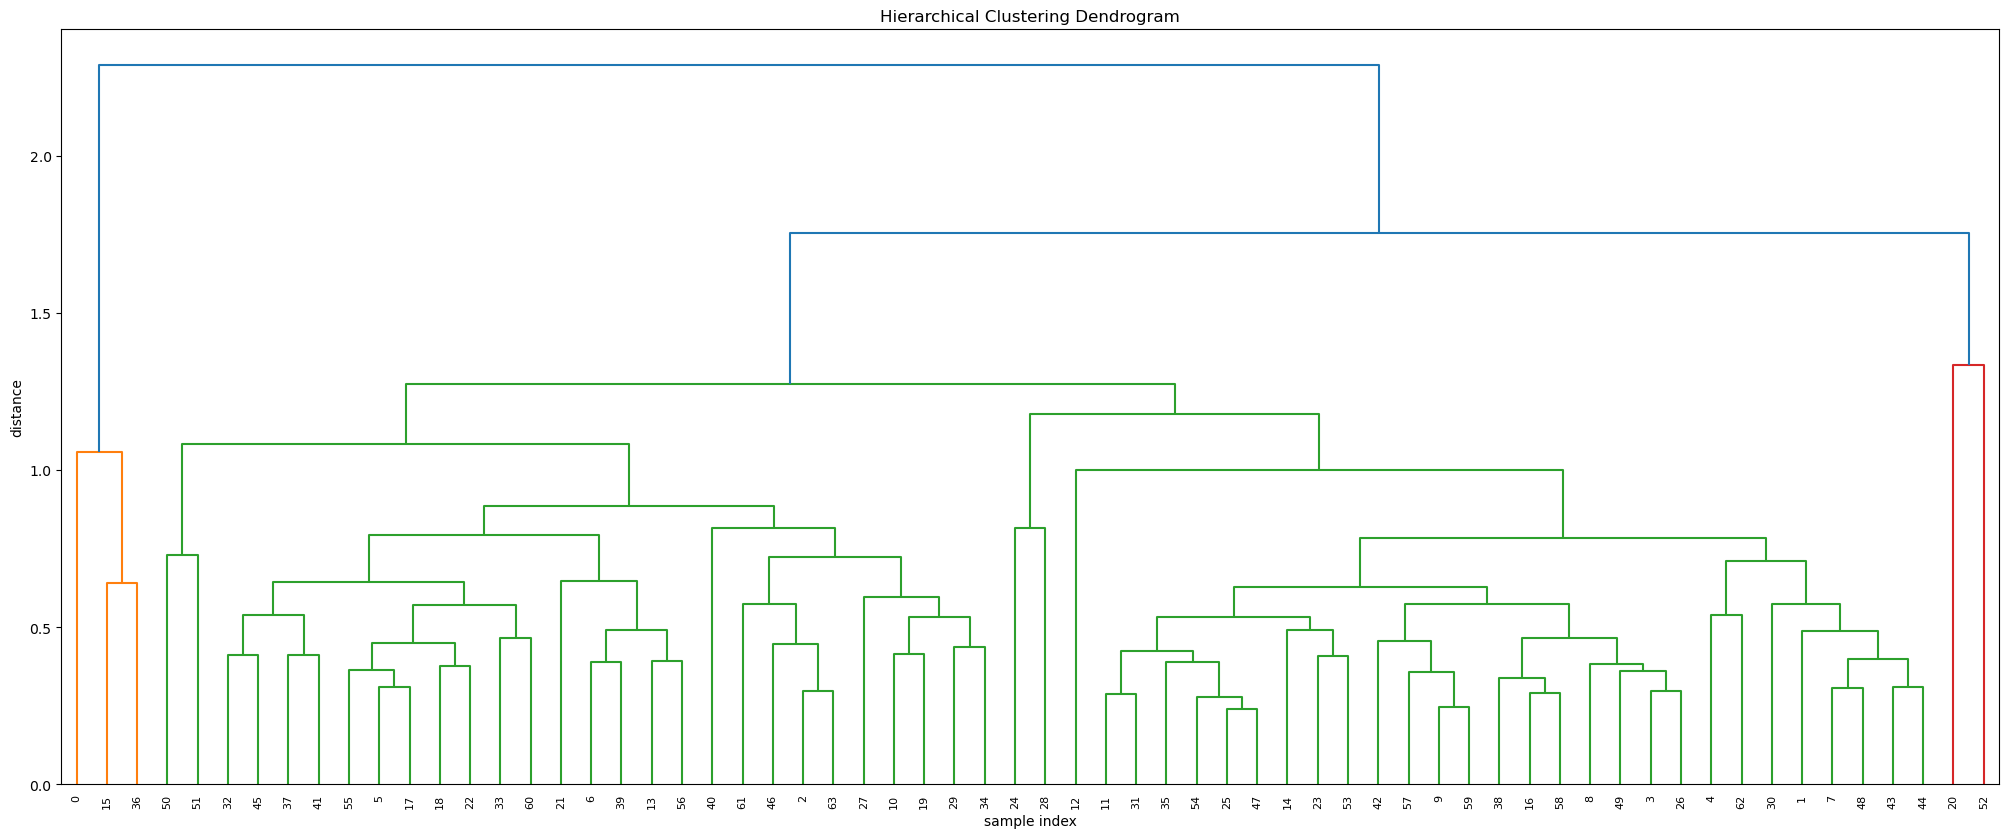

In [282]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
hac.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

In [283]:
clusters = pd.DataFrame([countries_v2,hac.fcluster(Z,t=3,criterion='maxclust')]).T

In [284]:
clusters.columns = ['country','cluster']
communities = [  set(clusters[clusters.cluster==clus].country.values) for clus in clusters.cluster.unique() ]

cluster
1    AxesSubplot(0.125,0.2;0.775x0.68)
2    AxesSubplot(0.125,0.2;0.775x0.68)
3    AxesSubplot(0.125,0.2;0.775x0.68)
dtype: object

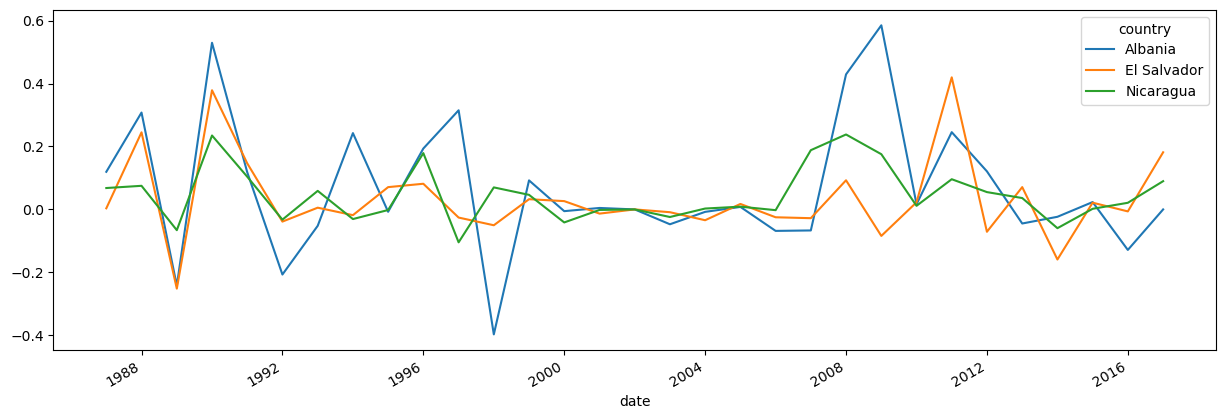

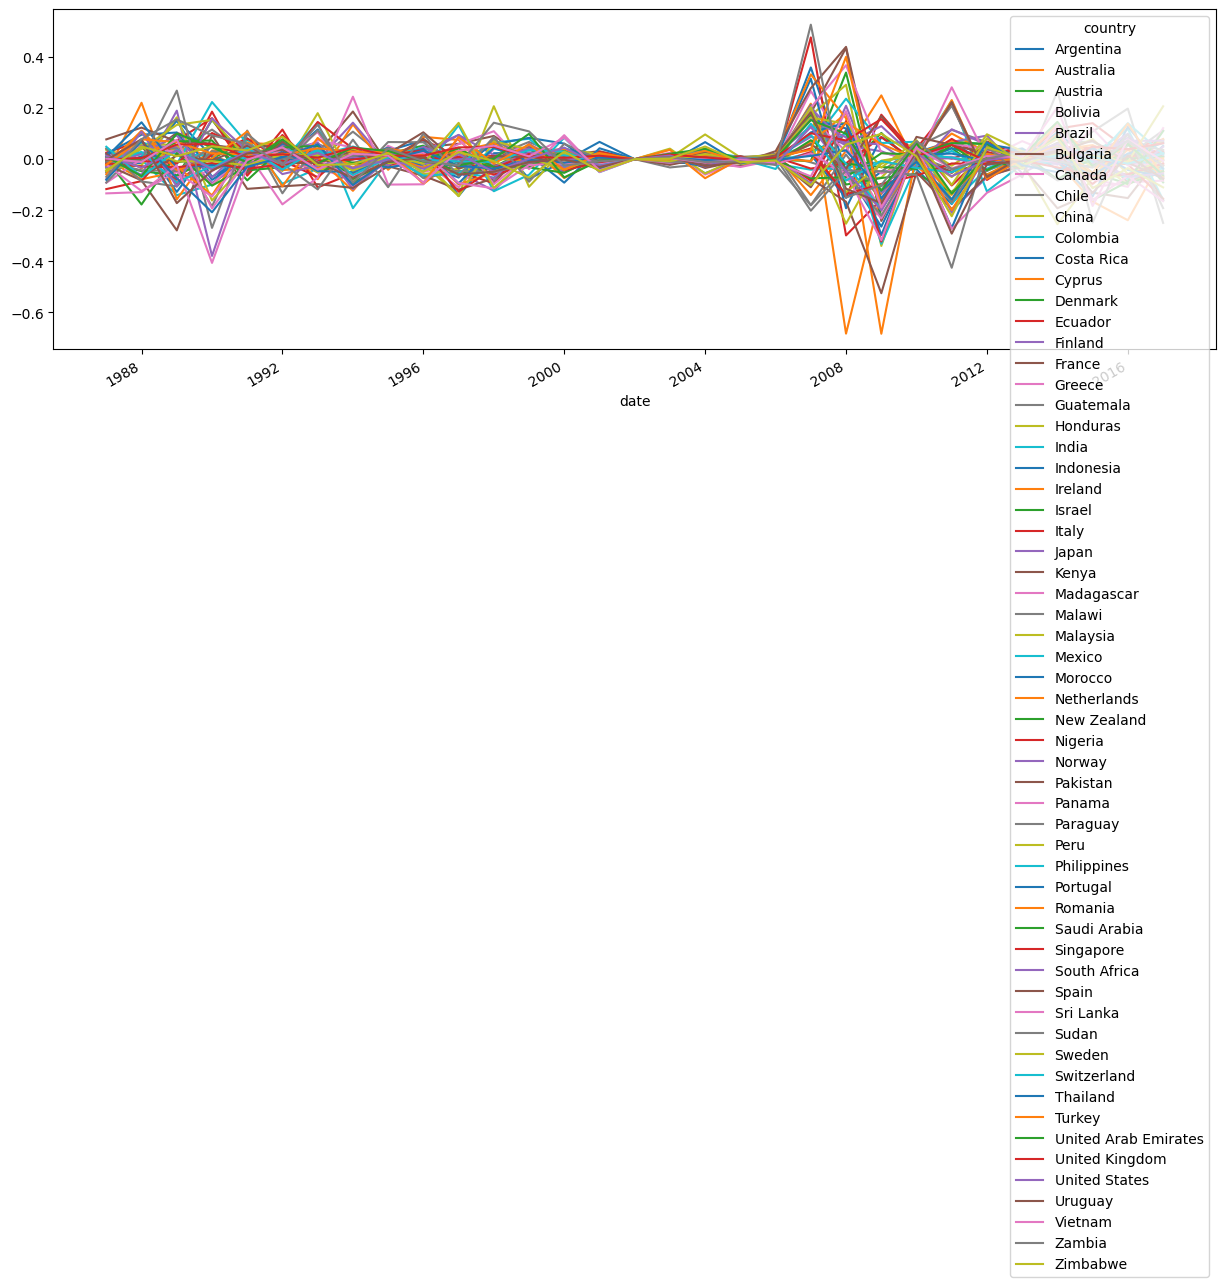

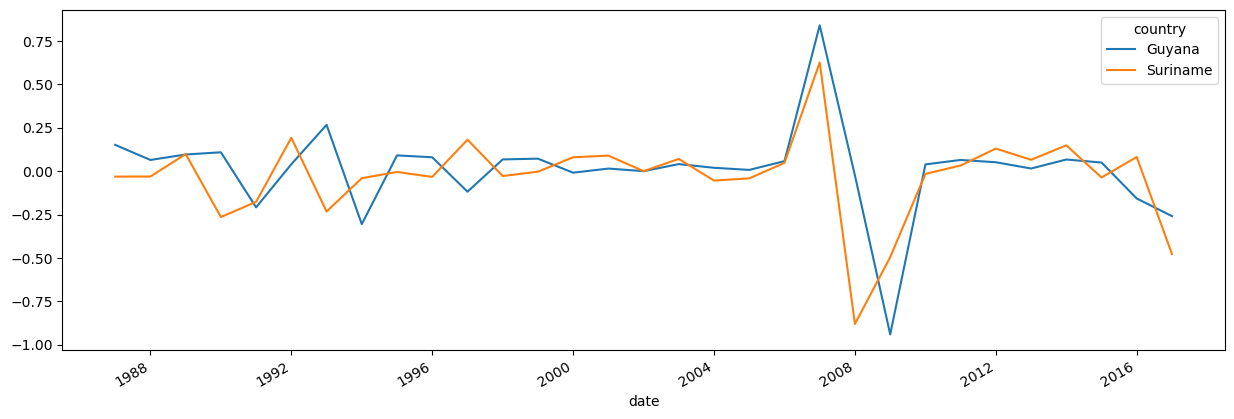

In [285]:
# for cluster, countries in clusters.groupby('cluster'):
#     print(cluster)
#     print("---------------------")
#     print(countries)
    
clusters.groupby('cluster').apply(lambda x: X[0].loc[x['country'],:].T.plot()  )

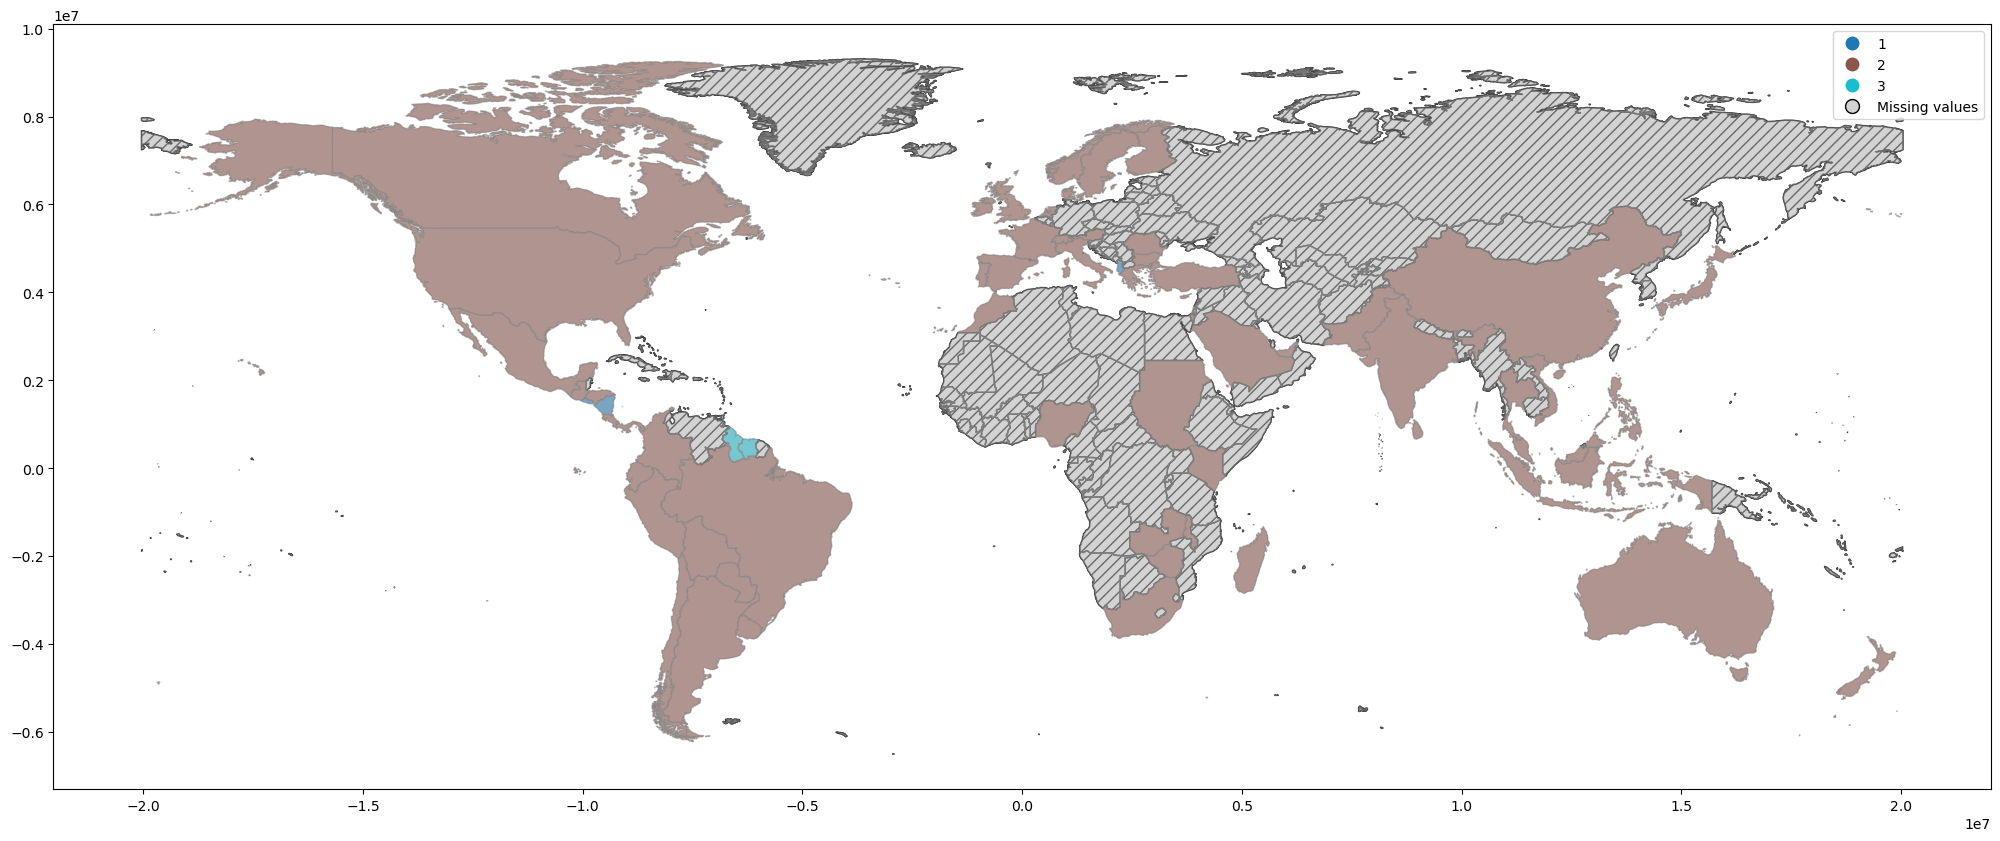

In [286]:
explore()

In [224]:
def explore(plot_network=False):
    plt.rcParams.update({'figure.figsize': (15, 10)})
    
    if plot_network:

        # Set node and edge communities
        set_node_community(G,communities)
        set_edge_community(G)

        # Set community color for internal edges
        external = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] == 0]
        internal = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] > 0]
        internal_color = ["black" for e in internal]
        node_color = [get_color(G.nodes[v]['community']) for v in G.nodes]

        pos=nx.spring_layout(G,k=0.3)

        # external edges
        # Draw external edges
        nx.draw_networkx(
            G,
            pos=pos,
            node_size=0,
            edgelist=external,
            edge_color="silver")
        #Draw nodes and internal edges
        nx.draw_networkx(
            G,
            pos=pos,
            node_color=node_color,
            edgelist=internal,
            edge_color=internal_color)


    world=gpd.read_file('../world_shapefiles/Longitude_Graticules_and_World_Countries_Boundaries-shp/99bfd9e7-bb42-4728-87b5-07f8c8ac631c2020328-1-1vef4ev.lu5nk.shp')
    world=world[world.CNTRY_NAME !='Antarctica']

    world_meters=world.to_crs(epsg=32663)

########### To add layer of links between countries with coloured nodes according to their community.
    
#     lines=[]
#     for country1,country2 in G.edges:
#         try:
#             centroid1=world_meters[world_meters['CNTRY_NAME']==country1].centroid.values[0]
#             centroid2=world_meters[world_meters['CNTRY_NAME']==country2].centroid.values[0]
#             lines.append( linestring.LineString([centroid1,centroid2]))
#         except IndexError as e:
#             pass


#     centroids=[]
#     c_nodes=[]
#     for country in G.nodes:
#         try:
#             c=world_meters[world_meters['CNTRY_NAME']==country].centroid.values[0]
#             centroids.append(c)
#             c_nodes.append(country)
#         except IndexError as e:
#             print(country)

#     lines=gpd.GeoSeries(lines)

#     node_color = [get_color(G.nodes[v]['community']) for v in G.nodes if v in c_nodes]

#     centroids=gpd.GeoDataFrame(centroids,columns=['Cent'])
#     centroids['colour']=node_color
#     centroids=centroids.set_geometry('Cent')

###################################################################################

    fig,ax=plt.subplots(figsize=(25,30)) 
    missing_kwds={"color": "lightgrey","edgecolor": "black","hatch": "///","label": "Missing values"}
    
    world_meters=world_meters.set_geometry('geometry')
    
    world_meters=pd.merge_ordered(world_meters.to_crs(epsg=32663),clusters,left_on='CNTRY_NAME',right_on='country',how='outer')
    world_meters=world_meters.set_geometry('geometry')
    world_meters.plot(column='cluster',missing_kwds=missing_kwds,ax=ax,legend=True)
    
    world_meters.plot(color='lightgrey',
                      edgecolor='grey',
                      alpha=.5,
                      ax=ax)

#     lines.plot(alpha=.2,ax=ax,color='black')
#     centroids.plot(color=centroids.colour,markersize=50,ax=ax,marker='o')
    
    plt.show()

In [83]:
treshold=.8
connected_countries=dissim[dissim < treshold].fillna(0)
np.fill_diagonal(connected_countries.values,0)

In [84]:
G = nx.Graph()
# connected_countries=dissim
for country1,series in connected_countries.iteritems():
    for country2,proximity in series.iteritems():
        if not np.isclose(proximity,0):  
            G.add_edge(country1,country2,weight=1/proximity)

In [62]:
# result = nxcom.girvan_newman(G)
# communities = next(result)
# len(communities)

In [63]:
# communities = next(result)
# len(communities)

In [77]:
communities = nxcom.greedy_modularity_communities(G,weight='weight')
temp = {}
for i,x in enumerate(communities):
    for y in x:
        temp[y] = i

_count=[x for x in partition.keys()]
_clust=[x for x in partition.values()]


clusters=pd.DataFrame({'country':_count,'cluster':_clust})
clusters.cluster=clusters.cluster.astype('object')

In [85]:
partition=community.best_partition(G)

temp={key:set() for key in partition.values()}

for key,val in partition.items():
    temp[val].add(key)

communities = [ lists_countries for cluster,lists_countries in temp.items()]

In [86]:
_count=[x for x in partition.keys()]
_clust=[x for x in partition.values()]

In [87]:
clusters=pd.DataFrame({'country':_count,'cluster':_clust})
clusters.cluster=clusters.cluster.astype('object')

In [88]:
len(communities)

3